# 1) Install and import dependencies:

In [1]:
# !pip install tensorflow==2.13.0

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# For data manipulation
import numpy as np 
import pandas as pd 
from PIL import Image
import matplotlib.pyplot as plt

# For data visualization
import matplotlib.pyplot as plt 
import seaborn as sns

# Ingore the warnings
import warnings
warnings.filterwarnings('ignore')

# DL Libraries
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, AveragePooling2D
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam

# Other libraries
import os
import random

2024-08-20 09:41:48.982743: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 09:41:48.982797: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 09:41:48.984380: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
tensorflow.__version__ , keras.__version__

('2.15.0', '3.4.1')

In [5]:
print("Keras version:", tensorflow.keras.__version__)  

Keras version: 3.4.1


In [6]:
from platform import python_version

print(python_version())

3.10.13


# 2) Load imgaes from train and test directories of the dataset:

### After experimenting with different image sizes and batch sizes, it was found that a relatively larger batch size of 160 images per batch and an image size of 256x256 gave the best performance.
### Having a larger batch size allows the model to learn from more images per batch, leading to a better overall accuracy
### The images in the dataset are of varying sizes but generally smaller in size. We started off with a smaller 128x128 image size and gradually made our way up to 512x512, it was found that the accuracy and loss figures at 256x256 and 512x512 were almost the same, however the smaller image size would lead to slighlty faster training times
### The only processing done here is resizing the images, as performaing rotation and shearing would harm the model performance, as the different types of tumors are shape and orientation dependent

In [7]:
BATCH_SIZE = 160

train_ds = keras.utils.image_dataset_from_directory(
    directory = r'/kaggle/input/mri-scans-brain-tumor-image-dataset/brain_tumor/brain_tumor/Training',
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=(256, 256),
)

val_ds = keras.utils.image_dataset_from_directory(
    directory = r'/kaggle/input/mri-scans-brain-tumor-image-dataset/brain_tumor/brain_tumor/Testing',
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=(256, 256),
)


test_ds = keras.utils.image_dataset_from_directory(
    directory = r'/kaggle/input/mri-scans-brain-tumor-image-dataset/brain_tumor/brain_tumor/Validation',
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=(256, 256),
)

Found 5712 files belonging to 4 classes.
Found 1111 files belonging to 4 classes.
Found 200 files belonging to 4 classes.


In [8]:
def count_images_in_folder(folder_split):
    subfolders = []
    folder_path = r'/kaggle/input/mri-scans-brain-tumor-image-dataset/brain_tumor/brain_tumor/'+folder_split
    for root, dirs, files in os.walk(folder_path):
        subfolders.extend(dirs)
        break
    
    
    
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']  # Add more extensions if needed
#     count = 0
    for i in subfolders:
        count = 0
        for root, dirs, files in os.walk(folder_path+'/'+i):
            for file in files:
                if file.lower().endswith(tuple(image_extensions)):
                    count += 1
                    
                    
        print(folder_split," :Number of images in the ",i," folder:", count)


In [9]:
count_images_in_folder('Training')
print("===========================")
count_images_in_folder('Testing')
print("===========================")
count_images_in_folder('Validation')

Training  :Number of images in the  pituitary  folder: 1457
Training  :Number of images in the  notumor  folder: 1595
Training  :Number of images in the  meningioma  folder: 1339
Training  :Number of images in the  glioma  folder: 1321
Testing  :Number of images in the  pituitary  folder: 250
Testing  :Number of images in the  notumor  folder: 355
Testing  :Number of images in the  meningioma  folder: 256
Testing  :Number of images in the  glioma  folder: 250
Validation  :Number of images in the  pituitary  folder: 50
Validation  :Number of images in the  notumor  folder: 50
Validation  :Number of images in the  meningioma  folder: 50
Validation  :Number of images in the  glioma  folder: 50


In [10]:
classes = train_ds.class_names
classes

['glioma', 'meningioma', 'notumor', 'pituitary']

# 3) Define model architecture and compile:
### We experimented with different architectures, starting with the AlexNet architecture and gradually started downsizing in terms of the FC layers first and then the Conv2D layers, as the FC layers generally have the most weights and are responsible for most of the model size
### Reducing the model size was a concern as the model had to be deployed on the cloud and bigger models are generally hard to work with when using a free tier account
### Another method worth exploring would be quantization of the model using quantization aware training of tensorflow

In [11]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal', input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(128, kernel_size=(3, 3),activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D())    
    
model.add(Flatten())

model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 230400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    58,982,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,396,676 (226.58 MB)

 Trainable params: 59,395,780 (226.58 MB)

 Non-trainable params: 896 (3.50 KB)

### Adam is used as an optimizer here as it by far is the best optimization algorithm available
### Accuracy is used as a metric here, however if the dataset was imbalanced, we would use recall as a metric

In [12]:
# Compile the model
from keras.metrics import Precision, Recall


model.compile(optimizer= Adam(), loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# 4) Train model:
### Initially the model was trained for 100 epochs, during which the accuracy on training and validation datasets gradually increased until it hit a peak around epoch 30 plateaued for a bit post that and then suddenly dropped with the loss increasing rapidly
### These hinted at a exploding gradient problem, unfortunately, introducing Dropout layers didn't solve the problem, which is why we restricted the epochs to 20

In [13]:
# Train the model
history = model.fit(train_ds, epochs=20, validation_data=val_ds, verbose=1)

Epoch 1/20


2024-08-20 09:43:00.513016: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,3,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[160,3,256,256]{3,2,1,0}, f32[160,64,254,254]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-20 09:43:00.854889: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.341982175s
Trying algorithm eng0{} for conv (f32[64,3,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[160,3,256,256]{3,2,1,0}, f32[160,64,254,254]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-20 09:43:04.943513: E external/local_xla/xla/service/sl

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - accuracy: 0.5725 - loss: 9.5858

2024-08-20 09:44:45.978705: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,3,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[112,3,256,256]{3,2,1,0}, f32[112,64,254,254]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-20 09:44:46.215638: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.237040904s
Trying algorithm eng0{} for conv (f32[64,3,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[112,3,256,256]{3,2,1,0}, f32[112,64,254,254]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
W0000 00:00:1724147110.214258     230 graph_launch.cc:671] Fall

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5761 - loss: 9.4607   

W0000 00:00:1724147111.783392     230 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


36/36 ━━━━━━━━━━━━━━━━━━━━ 235s 4s/step - accuracy: 0.5795 - loss: 9.3424 - val_accuracy: 0.3195 - val_loss: 440.3256
Epoch 2/20


W0000 00:00:1724147150.736676     229 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


36/36 ━━━━━━━━━━━━━━━━━━━━ 27s 753ms/step - accuracy: 0.8367 - loss: 1.6367 - val_accuracy: 0.3870 - val_loss: 36.5622
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 41s 759ms/step - accuracy: 0.8994 - loss: 0.8568 - val_accuracy: 0.3699 - val_loss: 13.9750
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 28s 771ms/step - accuracy: 0.9366 - loss: 0.2462 - val_accuracy: 0.4653 - val_loss: 7.7710
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 27s 751ms/step - accuracy: 0.9445 - loss: 0.2375 - val_accuracy: 0.8254 - val_loss: 0.8553
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 27s 753ms/step - accuracy: 0.9593 - loss: 0.2483 - val_accuracy: 0.8515 - val_loss: 0.6885
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 27s 760ms/step - accuracy: 0.9701 - loss: 0.1019 - val_accuracy: 0.9172 - val_loss: 0.4699
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 27s 757ms/step - accuracy: 0.9792 - loss: 0.1479 - val_accuracy: 0.9469 - val_loss: 0.1671
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 27s 755ms/step - accuracy: 0.9786 - loss: 0.0529 - val_accuracy: 0.9

In [14]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

# 5) Visualize metrics:

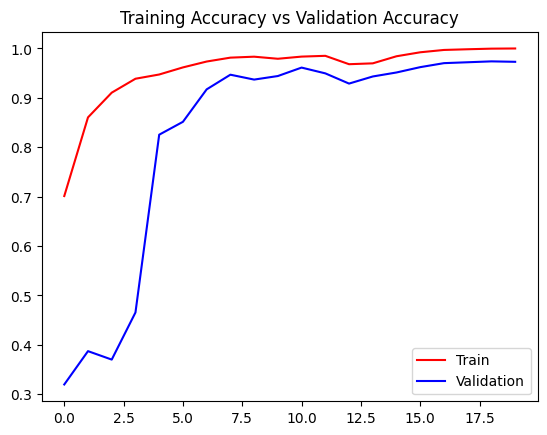

In [15]:
plt.title('Training Accuracy vs Validation Accuracy')

plt.plot(history.history['accuracy'], color='red',label='Train')
plt.plot(history.history['val_accuracy'], color='blue',label='Validation')

plt.legend()

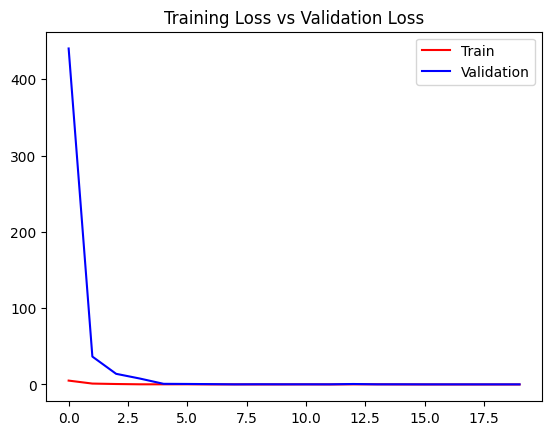

In [16]:
# Plotting the graph of Accuracy and Validation loss
plt.title('Training Loss vs Validation Loss')

plt.plot(history.history['loss'], color='red',label='Train')
plt.plot(history.history['val_loss'], color='blue',label='Validation')

plt.legend()

# 6) Check predictions on test images:

In [17]:
print("model metrics: ",model.metrics)

model metrics:  [<Mean name=loss>, <CompileMetrics name=compile_metrics>]


In [18]:
test_loss, test_acc = model.evaluate(test_ds)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.9608 - loss: 0.5054
Test accuracy: 0.9599999785423279
Test loss: 0.5796553492546082


W0000 00:00:1724147697.346656     229 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [19]:
# Load the image and resize to 256x256
def preprocess_test_image(test_image):
    img = Image.open("/kaggle/input/mri-scans-brain-tumor-image-dataset/" + test_image).resize((256, 256))
    # Convert image to numpy array
    img_array = np.array(img)

    # Check the shape of img_array
    print(img_array.shape)  # This should print (227, 227, 3) if it's RGB

    # If img_array is grayscale, convert it to RGB
    if len(img_array.shape) == 2:  # Check if it's grayscale
        img_array = np.stack((img_array,) * 3, axis=-1)  # Convert grayscale to RGB


    # Reshape and expand dimensions for model input
    img_array = img_array.reshape((1, 256, 256, 3))  # Reshape to (1, 227, 227, 3)

    # Now img_array should have the shape (1, 227, 227, 3)
    print(img_array.shape)
    
    return img_array
    
    
def test_input_image(test_image, alex_loaded):
    img_array = preprocess_test_image(test_image)

    prediction = alex_loaded.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    predicted_class = classes[predicted_class_index]
    print(predicted_class)

In [20]:
test_input_image("pitutory.jpg", model)

(256, 256)
(1, 256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
pituitary


# 7) Save the model:

In [21]:
# # model.save("mri_classifier_experiment1.h5")
# tensorflow.keras.models.save_model(model, 'mri_classifier_kaggle_v10.h5')

# 8) Visualize kernels and feature maps:

### We load the same model which we used for dployment and visualize the feature maps from the first convolution layer
### Visualizing the feature maps can give us an idea of what features the kernels are detecting

In [22]:
from tensorflow.keras.models import load_model

# alex_loaded = load_model("/kaggle/input/mri_classifier_v1/tensorflow2/default/1/mri_classifier.h5")

alex_loaded = load_model("/kaggle/input/mri_classifier_v1/tensorflow2/default/1/mri_classifier.h5")

In [23]:
test_input_image("glioma.jpg", alex_loaded)

(256, 256)
(1, 256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
glioma


In [24]:
alex_loaded.layers

[<Conv2D name=conv2d, built=True>,
 <BatchNormalization name=batch_normalization, built=True>,
 <MaxPooling2D name=max_pooling2d, built=True>,
 <Conv2D name=conv2d_1, built=True>,
 <BatchNormalization name=batch_normalization_1, built=True>,
 <MaxPooling2D name=max_pooling2d_1, built=True>,
 <Conv2D name=conv2d_2, built=True>,
 <BatchNormalization name=batch_normalization_2, built=True>,
 <MaxPooling2D name=max_pooling2d_2, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>,
 <Dense name=dense_2, built=True>,
 <Dense name=dense_3, built=True>]

In [25]:
alex_loaded.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 230400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    58,982,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,396,678 (226.58 MB)

 Trainable params: 59,395,780 (226.58 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 2 (12.00 B)

### The model has three convolution layers as shown below
### The first convolution layer has 64 3x3x3 kernels, the second has 128 3x3x64 kernels and the third has 256 3x3x128 kernerls
### we notice that as the depth of the CNN increases, the width and heigth of the images will decrease due to the convolution operation and the number of channels will keep increasing, the order by which the number of channels keep increasing is dependent on the number of kernels in each Convolution layer

In [26]:
for layer in alex_loaded.layers:
    
    if 'conv' not in layer.name:
        continue    
    filters , bias = layer.get_weights()
    print(layer.name , filters.shape)

conv2d (3, 3, 3, 64)
conv2d_1 (3, 3, 64, 128)
conv2d_2 (3, 3, 128, 256)


In [27]:
alex_loaded.layers

[<Conv2D name=conv2d, built=True>,
 <BatchNormalization name=batch_normalization, built=True>,
 <MaxPooling2D name=max_pooling2d, built=True>,
 <Conv2D name=conv2d_1, built=True>,
 <BatchNormalization name=batch_normalization_1, built=True>,
 <MaxPooling2D name=max_pooling2d_1, built=True>,
 <Conv2D name=conv2d_2, built=True>,
 <BatchNormalization name=batch_normalization_2, built=True>,
 <MaxPooling2D name=max_pooling2d_2, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>,
 <Dense name=dense_2, built=True>,
 <Dense name=dense_3, built=True>]

In [28]:
# retrieve weights from the first hidden layer
filters , bias = alex_loaded.layers[0].get_weights()

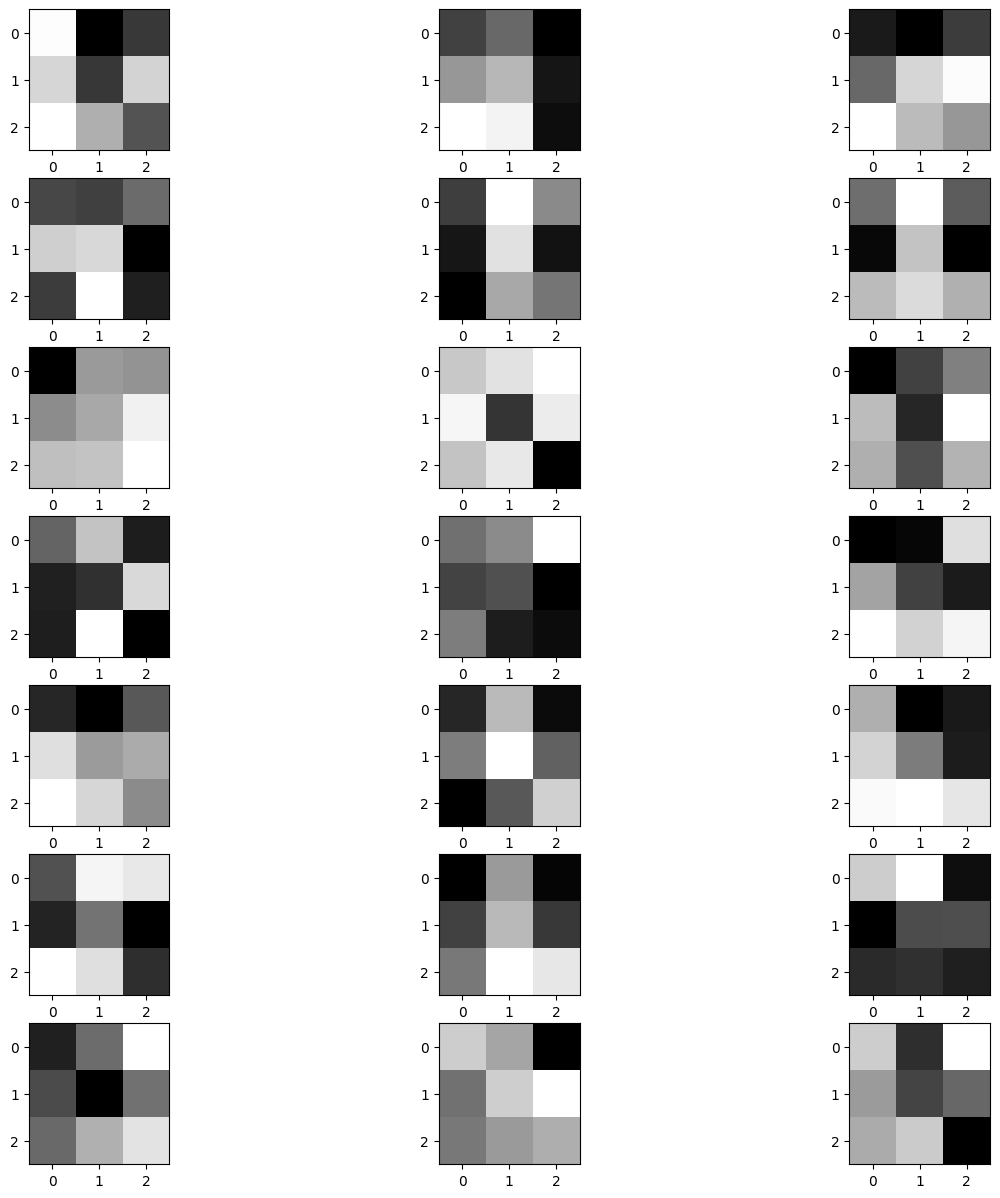

In [29]:
# VISUALIZING KERNELS OF FIRST LAYER:

n_filters = 7 # display first 7 kernels across 3 channels
ix=1
fig = plt.figure(figsize=(15,15))
for i in range(n_filters):
    # get the filters
    f = filters[:,:,:,i]
    for j in range(3):
        # subplot for 6 filters and 3 channels
        plt.subplot(n_filters,3,ix)
        plt.imshow(f[:,:,j] ,cmap='gray')
        ix+=1
#plot the filters 
plt.show()

### To have a look at what the output from each convolution layer is, we will use the functional method of defining a model, which will take in a test image as input and then pass the images through the subsequent convolution layers

In [30]:
# indexes of the convolution layers in the trained model
blocks = [0 ,3, 6]

# output tensors from the convolution layers of trained model
outputs = [alex_loaded.layers[i].output for i in blocks]

# Using functional API, we define the model which will take in a test image of size 256x256x3 and give us three outputs, one for each Convolution layer
model3 = tensorflow.keras.Model(inputs=alex_loaded.inputs , outputs=outputs)

model3.summary()

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 254, 254,  │      1,792 │ input_layer[0][0… │
│                     │ 64)               │            │ input_layer[0][0… │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 254, 254,  │        256 │ conv2d[3][0],     │
│ (BatchNormalizatio… │ 64)               │            │ conv2d[6][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 127, 127,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 125, 125,  │     73,856 │ max_pooling2d[1]… │
│                     │ 128)              │            │ max_pooling2d[4]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │        512 │ conv2d_1[3][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 62, 62,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 60, 60,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 371,584 (1.42 MB)

 Trainable params: 371,200 (1.42 MB)

 Non-trainable params: 384 (1.50 KB)

In [31]:
blocks = [0 ,3, 6]
outputs = [alex_loaded.layers[i].output for i in blocks]
model3 = tensorflow.keras.Model(inputs=alex_loaded.inputs , outputs=outputs)

(256, 256)
(1, 256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


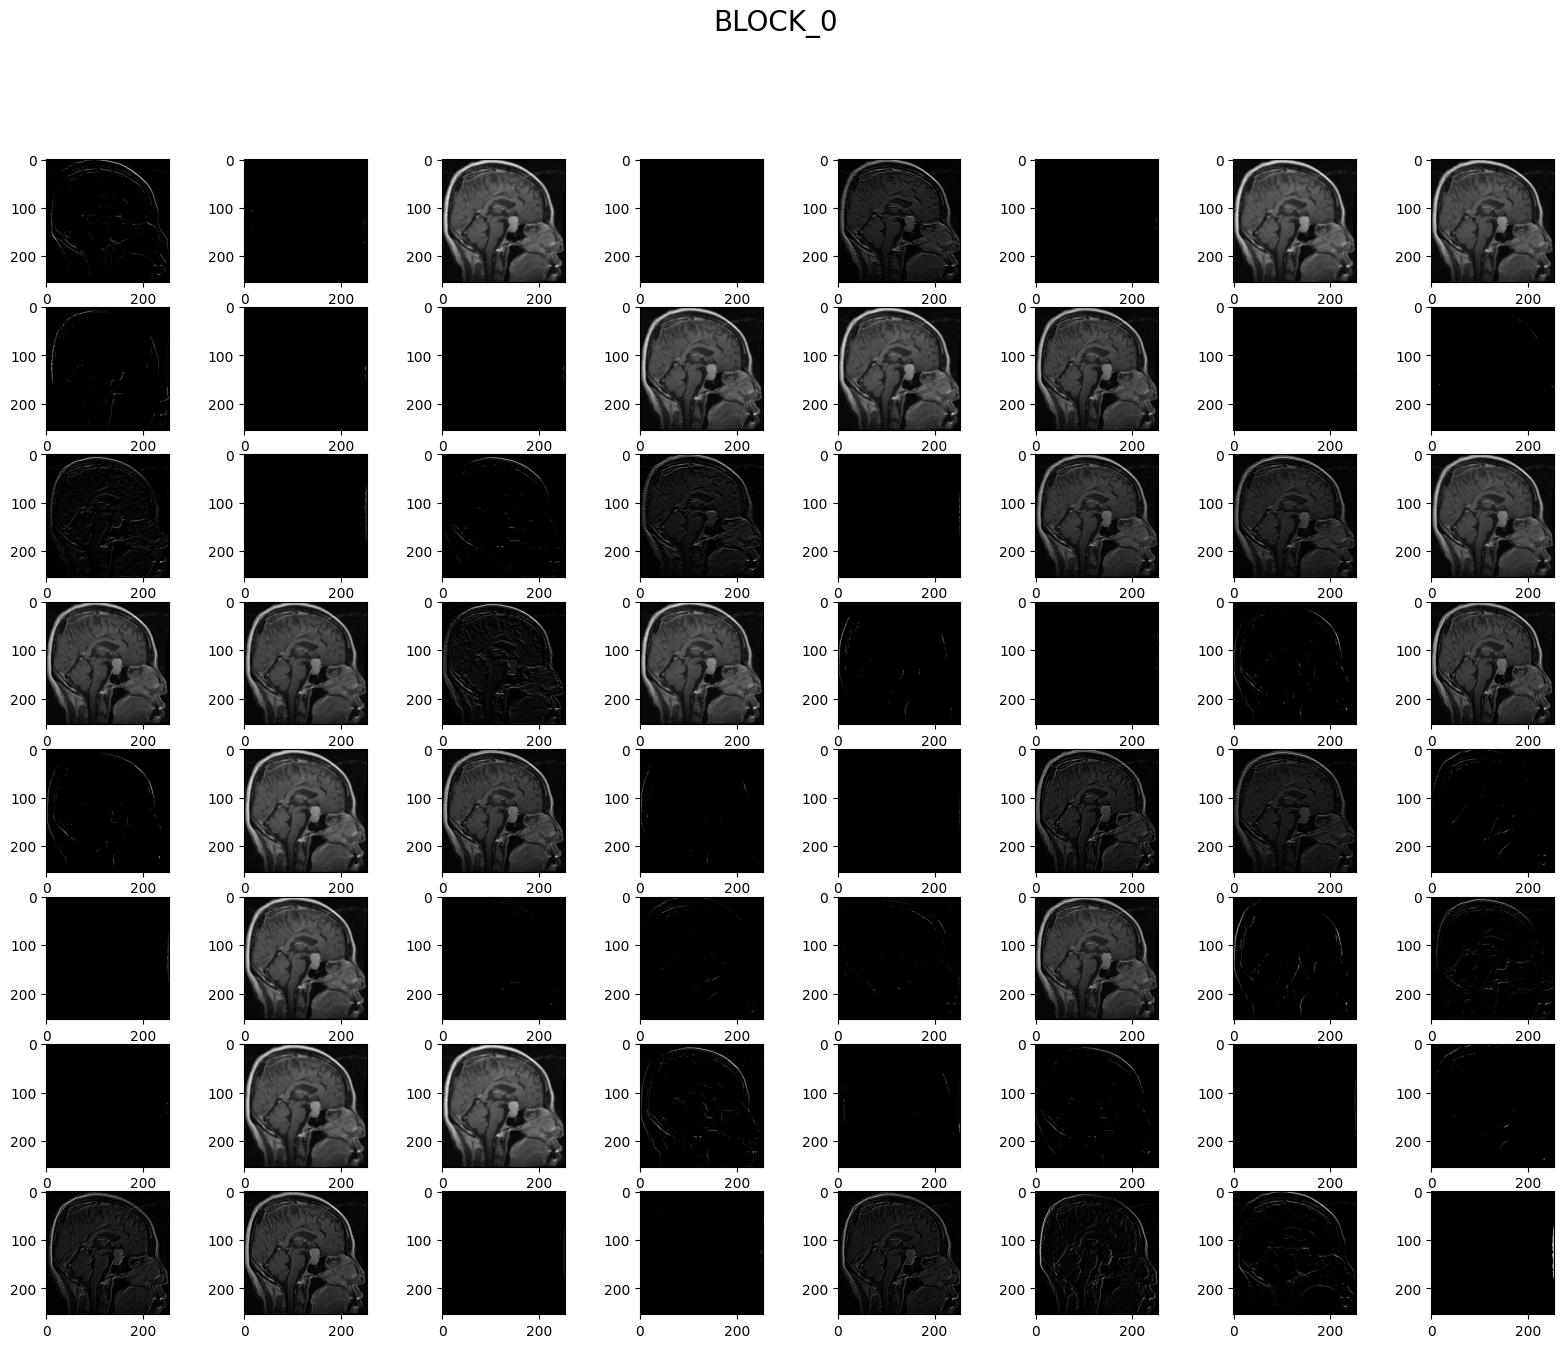

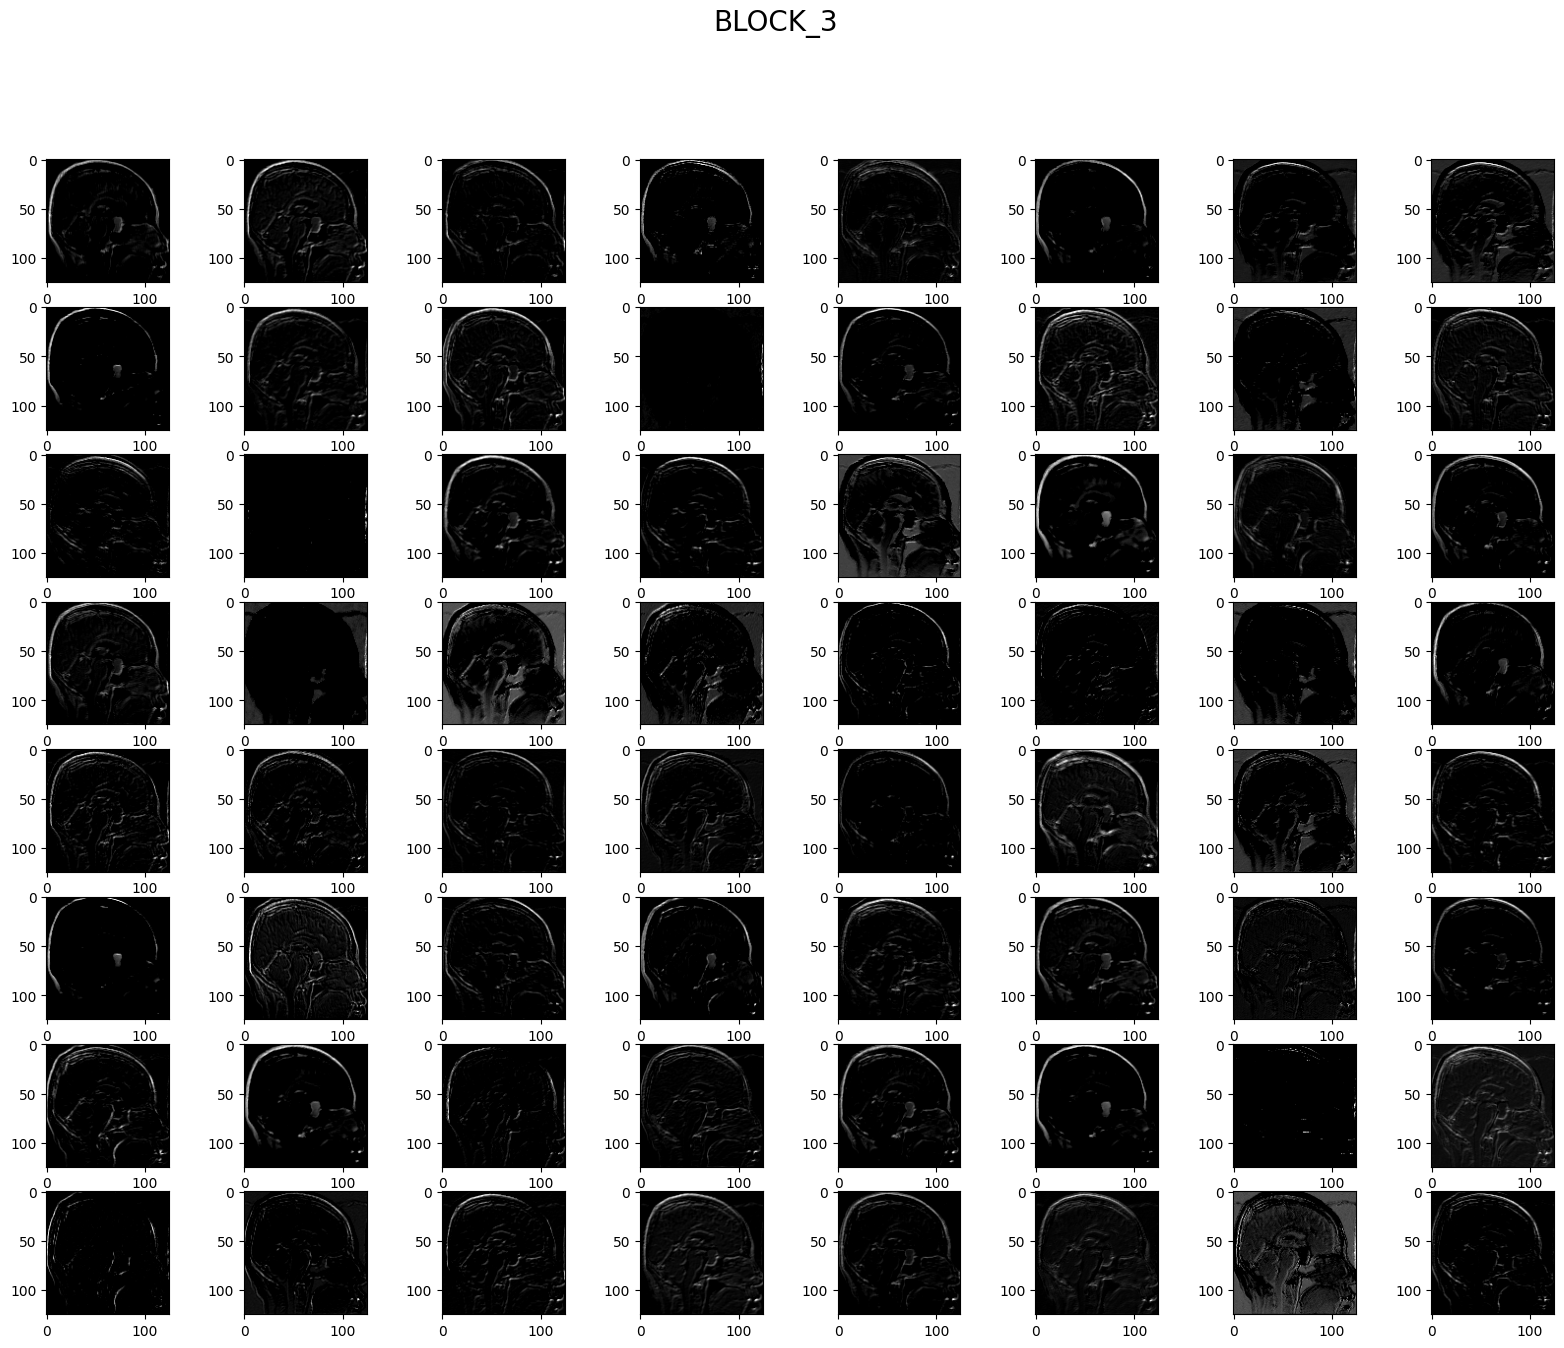

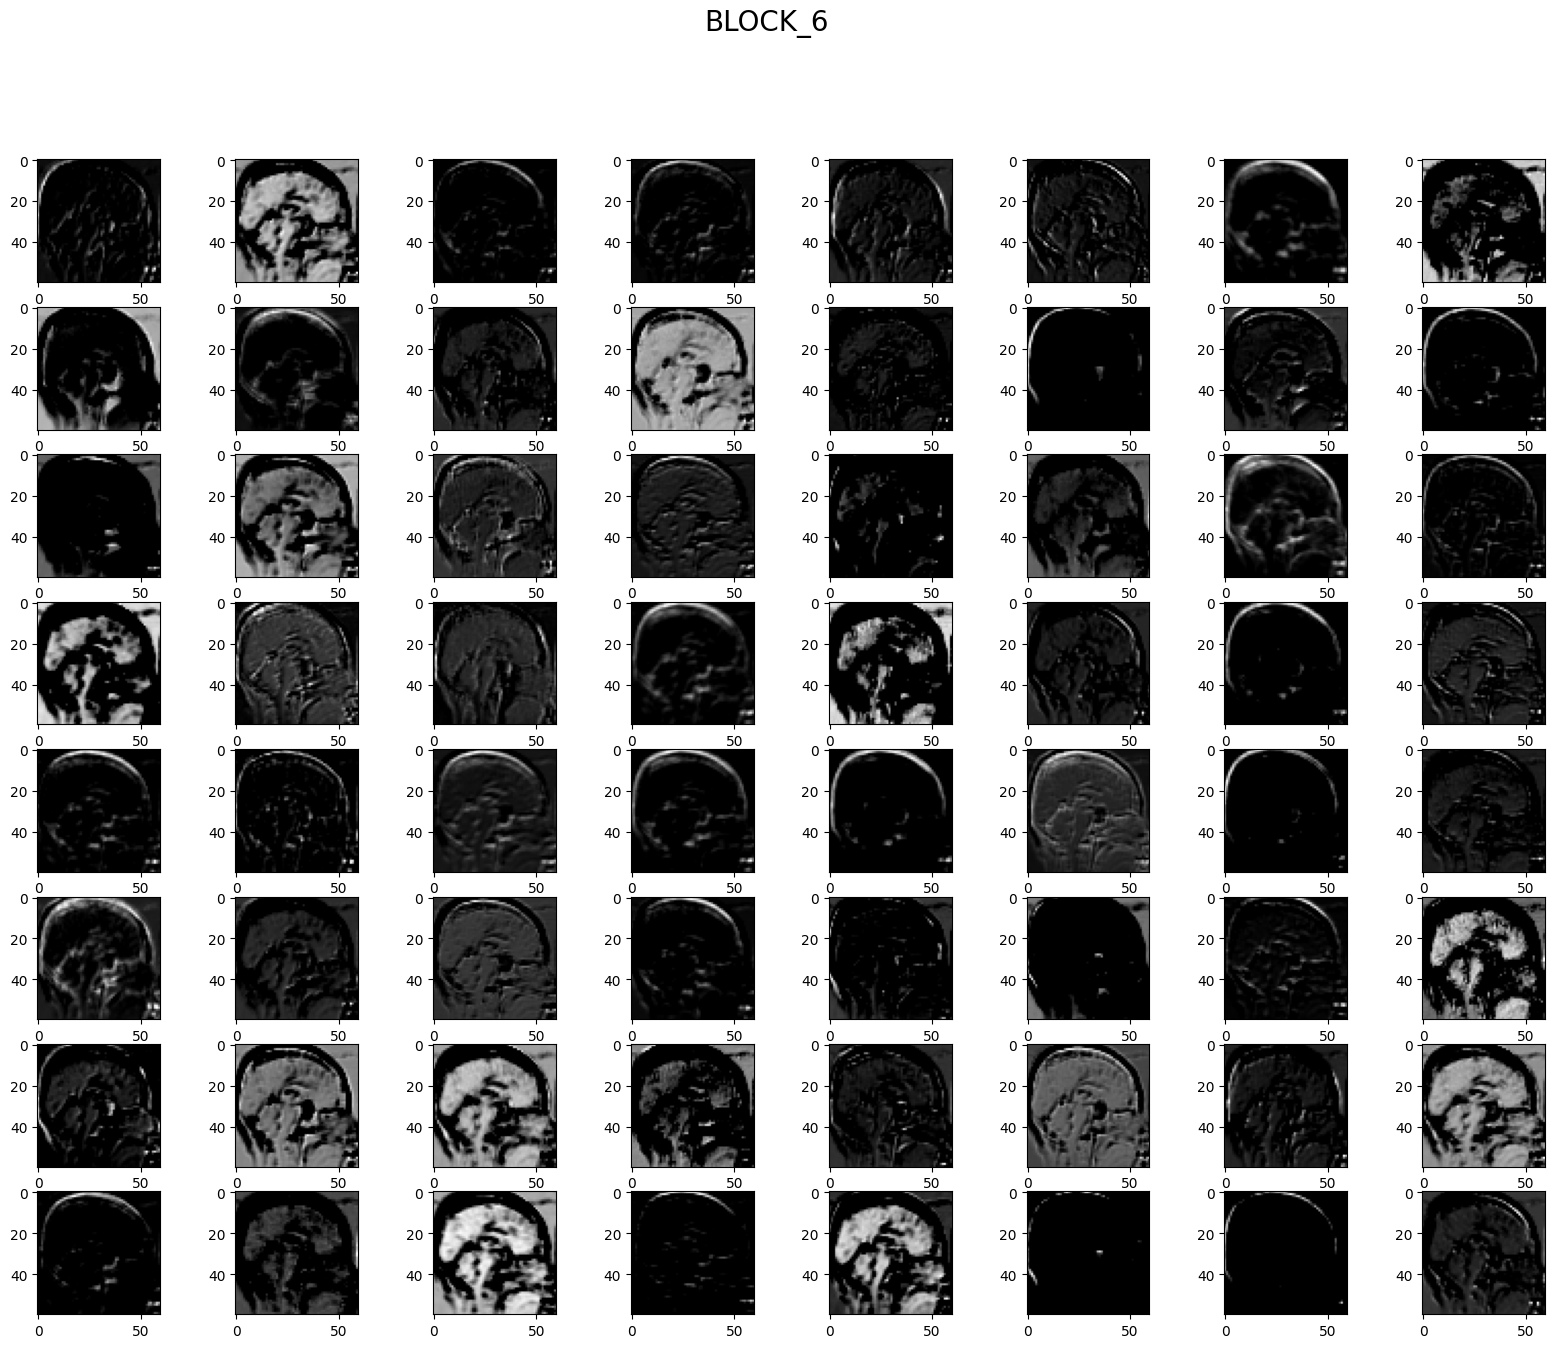

In [32]:
# first 64 filters from each conv layer:
image_output = preprocess_test_image("pitutory.jpg")
feature_map = model3.predict(image_output)

for i,fmap in zip(blocks,feature_map):
    fig = plt.figure(figsize=(20,15))
   
    fig.suptitle("BLOCK_{}".format(i) , fontsize=20)
    for j in range(1,feature_map[0].shape[3]+1):

        plt.subplot(8,8,j)
        plt.imshow(fmap[0,:,:,j-1] , cmap='gray')
    
plt.show()

**#############################################################################################**